The code here is based on the paper Evolutionary consequences of polyploidy in prokaryotes and the origin of mitosis and meiosis
https://biologydirect.biomedcentral.com/articles/10.1186/s13062-016-0131-8

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [31]:
class Cell:
    def __init__(self, initial_fitness=0.99, num_genes=100, ploidy=1):
        self.ploidy = ploidy
        self.num_genes = num_genes
        self.initial_fitness = initial_fitness
        self.genome = np.array([[initial_fitness for _ in range(num_genes)] for n in range(self.ploidy)])
        self.fitness = None
        self.effective_fitness = None
    
    def calculate_fitness(self):
        fitness = 1

        for i in range(self.num_genes):
            gene_fitness = np.max(self.genome[:, i])
            fitness *= gene_fitness/self.initial_fitness
        
        self.fitness = fitness
    
    def calculate_effective_fitness(self, population, s=0.3):
        min_fitness = population.min_fitness
        max_fitness = population.max_fitness
        divisor = (max_fitness - min_fitness) if max_fitness - min_fitness != 0 else 1

        self.effective_fitness = (1-s) * (self.fitness - min_fitness)/divisor + s * np.random.rand()
    
    def mutate(self, mutation_probability=0.007, beneficial_mutation_rate=0.01, k_deleterious=0.05, k_beneficial=0.1):
        for i, chromosome in enumerate(self.genome):
            for j, gene in enumerate(chromosome):
                mut = np.random.rand()

                if mut < mutation_probability:
                    beneficial = np.random.rand()

                    if beneficial < beneficial_mutation_rate:
                        self.genome[i, j] = 1 - (1 - gene) * (1 - k_beneficial)
                    else:
                        self.genome[i, j] = gene * (1 - k_deleterious)

    
    def divide(self, ploidy_reduction_prob=0):
        pr = np.random.rand()
        genome = np.copy(self.genome)

        new_cell_1 = None
        new_cell_1 = None

        if pr < ploidy_reduction_prob and self.ploidy > 1:
            np.random.shuffle(genome)

            new_ploidy_1 = math.floor(self.ploidy/2)
            new_ploidy_2 = self.ploidy - new_ploidy_1

            new_genome_1 = np.copy(genome[:new_ploidy_1])
            new_genome_2 = np.copy(genome[new_ploidy_1: self.ploidy])

            new_cell_1 = Cell(initial_fitness=self.initial_fitness, num_genes=self.num_genes, ploidy=new_ploidy_1)
            new_cell_1.genome = new_genome_1
            new_cell_2 = Cell(initial_fitness=self.initial_fitness, num_genes=self.num_genes, ploidy=new_ploidy_2)
            new_cell_2.genome = new_genome_2
        else:
            genome = np.repeat(genome, 2, axis=0)

            np.random.shuffle(genome)
            new_genome_1 = np.copy(genome[:self.ploidy])
            new_genome_2 = np.copy(genome[self.ploidy: 2*self.ploidy])

            new_cell_1 = Cell(initial_fitness=self.initial_fitness, num_genes=self.num_genes, ploidy=self.ploidy)
            new_cell_1.genome = new_genome_1
            new_cell_2 = Cell(initial_fitness=self.initial_fitness, num_genes=self.num_genes, ploidy=self.ploidy)
            new_cell_2.genome = new_genome_2
        

        return (new_cell_1, new_cell_2)

In [32]:
c = Cell(ploidy=5, num_genes=10)
c.divide(ploidy_reduction_prob=1)

2 3
2 3


(<__main__.Cell at 0x1227b6bd0>, <__main__.Cell at 0x1227a8a10>)

In [3]:
class Population:
    def __init__(self, size=4000, num_genes=100, ploidy=1):
        self.size = size
        self.cells = [Cell(num_genes=num_genes, ploidy=ploidy) for _ in range(size)]
        self.min_fitness = None
        self.max_fitness = None
    
    def __getitem__(self, i):
        return self.cells[i]

In [4]:
def run_simulation(
    size=200,
    ploidy=1,
    ploidy_reduction_prob=0.0,
    num_genes=100,
    mutation_probability=0.007,
    beneficial_mutation_rate=0.01,
    k_deleterious=0.05,
    k_beneficial=0.1,
    s=0.3,
    steps=500
):
    pop = Population(size=size, num_genes=num_genes, ploidy=ploidy)
    average_fitness = []
    genome_snapshot = np.array([[]])

    for i in range(steps):
        # cells reproduce
        new_cells = []

        for cell in pop.cells:
            new_cell_1, new_cell_2 = cell.divide(ploidy_reduction_prob=ploidy_reduction_prob)
            new_cells.append(new_cell_1)
            new_cells.append(new_cell_2)

        pop.cells = new_cells
        
        # mutate everyone
        for cell in pop.cells:
            cell.mutate(
                mutation_probability=mutation_probability,
                beneficial_mutation_rate=beneficial_mutation_rate,
                k_deleterious=k_deleterious,
                k_beneficial=k_beneficial
            )

        # calculate fitnesses
        for cell in pop.cells:
            cell.calculate_fitness()

        # kill cells with fitness below 0.5
        filtered_cells = [cell for cell in pop.cells if cell.fitness > 0.5]
        pop.cells = filtered_cells

        # get min and max fitness to calcualte effective fitness with
        if len(pop.cells) == 0: break

        fitnesses = [cell.fitness for cell in pop.cells]
        average_fitness.append(np.average(fitnesses))

        if len(pop.cells) < 2: break

        pop.min_fitness = np.min(fitnesses)
        pop.max_fitness = np.max(fitnesses)


        # calculate effective fitnesses
        for cell in pop.cells:
            cell.calculate_effective_fitness(pop, s=s)

        # sort population by effective fitness select top population_size cells
        pop.cells.sort(key=lambda x: x.effective_fitness)
        pop.cells = pop.cells[max(len(pop.cells) - pop.size, 0):]
    
    return average_fitness, genome_snapshot

In [5]:
size = 2500
num_genes = 50
mutation_probability = 0.01

average_fitness_6ploid, _ = run_simulation(
    size=size, ploidy=6, num_genes=num_genes, mutation_probability=mutation_probability, ploidy_reduction_prob=0
)
average_fitness_6ploid, _ = run_simulation(
    size=size, ploidy=6, num_genes=num_genes, mutation_probability=mutation_probability, ploidy_reduction_prob=0.2
)
average_fitness_6ploid, _ = run_simulation(
    size=size, ploidy=6, num_genes=num_genes, mutation_probability=mutation_probability, ploidy_reduction_prob=0.5
)

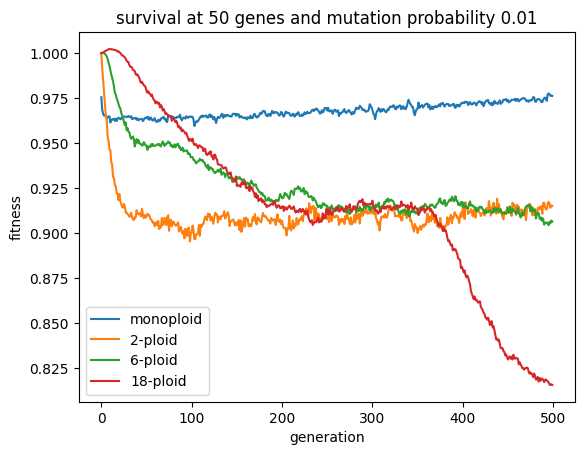

In [6]:
fig, ax = plt.subplots()

ax.plot(average_fitness_monoploid, label='monoploid')
ax.plot(average_fitness_2ploid, label='2-ploid')
ax.plot(average_fitness_6ploid, label='6-ploid')
ax.plot(average_fitness_18ploid, label='18-ploid')
ax.set_title("survival at 50 genes and mutation probability 0.01")
ax.set_ylabel('fitness')
ax.set_xlabel('generation')
ax.legend(loc="lower left")

In [7]:
fig.savefig('figure_3_reproduction.png')

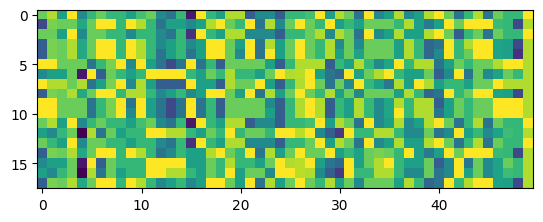

In [51]:
fig, ax = plt.subplots()
ax.imshow(genome_snapshot)